# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='notebook_ims/denoising.png' width=60%/>

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

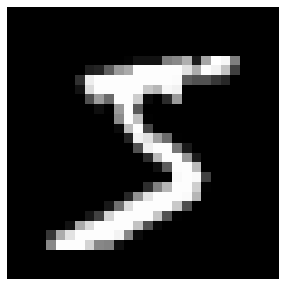

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
ax.axis('off')
plt.show()

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='notebook_ims/simple_autoencoder.png' width=50% />


#### TODO: Build the graph for the autoencoder in the cell below. 
> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. 
> The encoder and decoder will be made of two linear layers, each.
> The depth dimensions should change as follows: 784 inputs > **encoding_dim** > 784 outputs.
> All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

**The compressed representation should be a vector with dimension `encoding_dim=32`.**

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        
        self.flatten = nn.Flatten() # flatten the images
                                    # this will have no effect if 
                                    # the images are already flattened before passing them 
                                    # to the neural net
        self.encode = nn.Linear(784, encoding_dim)
        
        ## decoder ##
        
        self.decode = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        x = self.flatten(x)
        x = self.encode(x)
        x = F.relu(x)
        x = self.decode(x)
        x = torch.sigmoid(x)
        
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (flatten): Flatten()
  (encode): Linear(in_features=784, out_features=32, bias=True)
  (decode): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [5]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.681430
Epoch: 2 	Training Loss: 0.362774
Epoch: 3 	Training Loss: 0.318415
Epoch: 4 	Training Loss: 0.309898
Epoch: 5 	Training Loss: 0.306632
Epoch: 6 	Training Loss: 0.304773
Epoch: 7 	Training Loss: 0.303388
Epoch: 8 	Training Loss: 0.302349
Epoch: 9 	Training Loss: 0.301493
Epoch: 10 	Training Loss: 0.300761
Epoch: 11 	Training Loss: 0.300095
Epoch: 12 	Training Loss: 0.299469
Epoch: 13 	Training Loss: 0.298881
Epoch: 14 	Training Loss: 0.298335
Epoch: 15 	Training Loss: 0.297813
Epoch: 16 	Training Loss: 0.297321
Epoch: 17 	Training Loss: 0.296849
Epoch: 18 	Training Loss: 0.296400
Epoch: 19 	Training Loss: 0.295980
Epoch: 20 	Training Loss: 0.295581


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

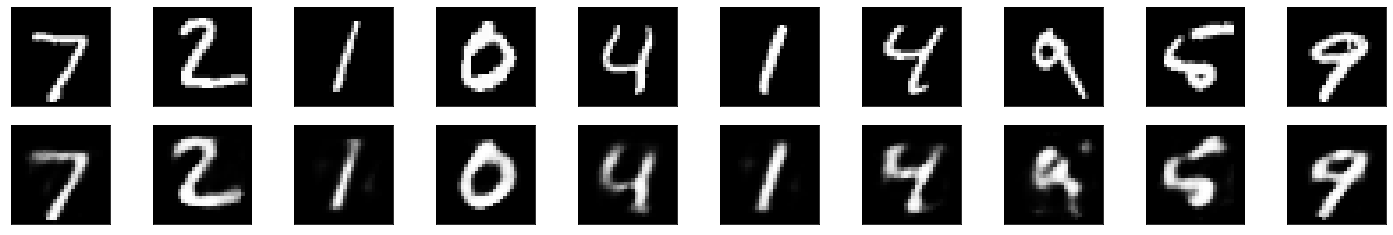

In [7]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_tst, labels_tst = dataiter.next()

images_flatten = images_tst.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images_tst = images_tst.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images_tst, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Using binary cross entropy loss

Recall that Aurelion Geron in his book [Hands-on Machine Learning](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) noted that 

    When compiling the stacked autoencoder, we use the binary crossentropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each pixel intensity represents the probability that the pixel should be black. Framing it this way (rather than as a regression problem) tends to make the model converge faster
    
Let us therefore try to train the same network with binary_cross_entropy loss. Pytorch's loss function to use in this case is [torch.nn.BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss). It is even mentioned explicitly in their documentation that : 

    This is used for measuring the error of a reconstruction in for example an auto-encoder.

In [11]:
# initialize the NN
encoding_dim = 32
model_cross_entropy_loss = Autoencoder(encoding_dim)
print(model_cross_entropy_loss)

# specify loss function
criterion = nn.BCELoss() 
# specify loss function
optimizer = torch.optim.Adam(model_cross_entropy_loss.parameters(), lr=0.001)

# also compute mse simultaneously to compare the reconstruction error
mse = nn.MSELoss()

Autoencoder(
  (flatten): Flatten()
  (encode): Linear(in_features=784, out_features=32, bias=True)
  (decode): Linear(in_features=32, out_features=784, bias=True)
)


In [12]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_cross_entropy_loss(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
        # reconstruction_error
        error = mse(outputs, images)
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f} \tReconstruction Error: {:.6f}'.format(
        epoch, train_loss, error))

Epoch: 1 	Training Loss: 3.335761 	Reconstruction Error: 0.023383
Epoch: 2 	Training Loss: 2.294855 	Reconstruction Error: 0.018031
Epoch: 3 	Training Loss: 2.147046 	Reconstruction Error: 0.017714
Epoch: 4 	Training Loss: 2.124817 	Reconstruction Error: 0.017702
Epoch: 5 	Training Loss: 2.115767 	Reconstruction Error: 0.017732
Epoch: 6 	Training Loss: 2.110050 	Reconstruction Error: 0.017774
Epoch: 7 	Training Loss: 2.105647 	Reconstruction Error: 0.017795
Epoch: 8 	Training Loss: 2.101983 	Reconstruction Error: 0.017794
Epoch: 9 	Training Loss: 2.098921 	Reconstruction Error: 0.017783
Epoch: 10 	Training Loss: 2.096321 	Reconstruction Error: 0.017767
Epoch: 11 	Training Loss: 2.094065 	Reconstruction Error: 0.017734
Epoch: 12 	Training Loss: 2.092120 	Reconstruction Error: 0.017689
Epoch: 13 	Training Loss: 2.090389 	Reconstruction Error: 0.017656
Epoch: 14 	Training Loss: 2.088850 	Reconstruction Error: 0.017625
Epoch: 15 	Training Loss: 2.087433 	Reconstruction Error: 0.017591
Epoc

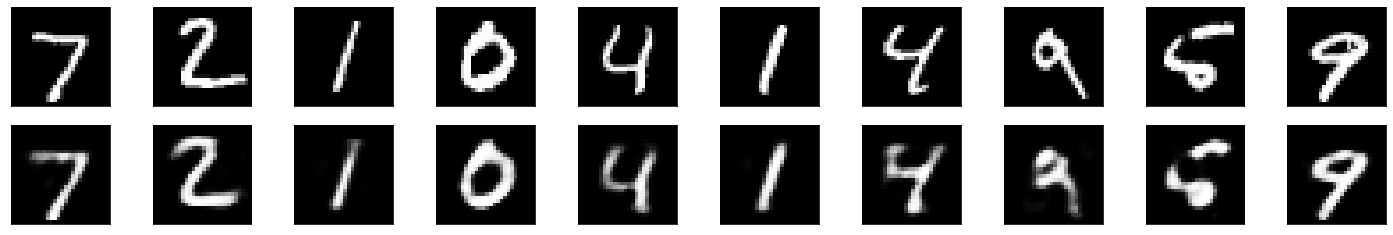

In [26]:
# test model_cross_entropy_loss on the same test images as before
# convert images_tst to a torch tensor
images_tst = torch.from_numpy(images_tst)
images_flatten = images_tst.reshape(images.size(0), -1)
# get sample outputs
output = model_cross_entropy_loss(images_flatten)
# prep images for display
images_tst = images_tst.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images_tst, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

When training with BCELoss(), we see that the recontruction error is smaller and therefore we will need to train for a smaller number of epochs as opposed to when we trained with MSELoss(). We also see that when using BCELoss(), the result for test images is slightly better. For e.g. consider the reconstruction of the digit '9' in the 8-th image (from right). With MSELoss(), the tail of the reconstructed image was much fuzzier than with the BCELoss(). 

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.